# Wellflow quick tutorial

This notebook demonstrates a minimal, clear workflow for reading plate data, blank-correcting, smoothing, estimating growth rate (mu), and summarizing mu-max per well.

Sections:

1. Quick imports and notes about API names (we prefer the non-mutating `with_` helpers).
2. Read data and merge layout.
3. Blanking, smoothing, growth-rate estimation.
4. Visualizations and grouping by conditions.

Prerequisites: run the notebook inside the project venv (or a conda env with pandas/numpy/scipy/openpyxl).

In [66]:
from wellflow import (
    read_plate_measurements,
    read_plate_layout,
    merge_measurements_and_conditions,
    read_flagged_wells,
    add_flag_column,
    drop_flags,
    with_blank_corrected_od,
    with_smoothed_od,
    add_growth_rate,
    summarize_mu_max,
    estimate_early_od_threshold,
)

import seaborn as sns
import matplotlib.pyplot as plt

In [67]:
path_to_data = "Growth_curve_Ecoli_AmbCO2_07252025.xlsx"
path_to_layout= "ecoli_layout.xlsx"

In [68]:
# Read measurements and plate layout using the current API signature
# For Gen5 wide kinetics: reader_model="Synergy H1", data_format="wide", timepoint_cols=["Time"]
raw = read_plate_measurements(
    "Synergy H1",
    "wide",
    ["Time"],
    path_to_data,
    header_row=44,
    last_row=237,
    start_col="B",
)
# read the plate layout (column-blocks format)
layout = read_plate_layout(path_to_layout, data_format="column_blocks")
merged = merge_measurements_and_conditions(raw, layout)

### Blank correction: subtract initial baseline per well

Blanking removes baseline signal (e.g., media/background). We average the first N timepoints per well and subtract that value so early noise doesn't dominate.

Guideline: choose window ≈ 0.1 × doubling time (e.g., 4 points here).


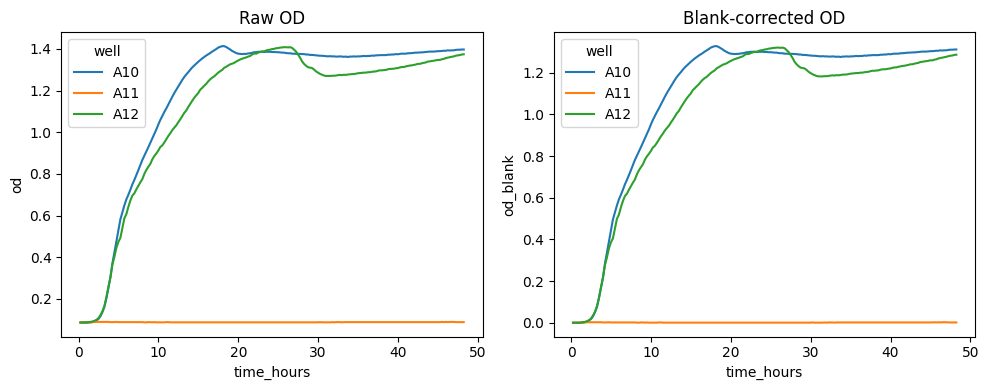

In [69]:
# Compute blank-corrected OD and compare with raw OD
blanked = with_blank_corrected_od(merged, window=4)

# Choose a few wells to inspect
mask = blanked[(blanked["well"] == "A10") | (blanked["well"] == "A11") | (blanked["well"] == "A12")]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
axes[0].set_title("Raw OD")
sns.lineplot(data=mask, x="time_hours", y="od", hue="well", ax=axes[0])
axes[1].set_title("Blank-corrected OD")
sns.lineplot(data=mask, x="time_hours", y="od_blank", hue="well", ax=axes[1])
plt.tight_layout()

In [70]:
# Blanking, smoothing, growth-rate estimation, and mu-max summarization.
# Prefer the non-mutating "with_" helpers which return a new DataFrame each time.
blanked = with_blank_corrected_od(merged, 4)  # ~0.1 × T_d
# Legacy alias: add_blank_value(merged, 4)

smoothed = with_smoothed_od(blanked, window=5)  # ~0.2–0.3 × T_d
# Legacy alias: add_smoothed_od(blanked, window=5)

with_mu = add_growth_rate(smoothed, window=10)  # window_duration ≈ 0.5–1.0 × T_d

# Estimate threshold from BLANKED OD (od_blank) to reflect baseline without smoothing
threshold = estimate_early_od_threshold(blanked, od_col="od_blank", n_points=5, q=0.95)

# Summarize mu-max per well (mu_max, tau, confidence intervals) using SMOOTHED OD (od_smooth)
max_mu = summarize_mu_max(with_mu, window=5, od="od_smooth", threshold=threshold)
# Legacy alias: mu_max_create(with_mu)
full = with_mu

No meaningful growth found for this group:B11
No meaningful growth found for this group:C11
No meaningful growth found for this group:D11
No meaningful growth found for this group:D11


### Flagging suspect wells (exclude problematic data)

We can mark specific wells as problematic (e.g., edge effects, sensor errors) and exclude them from downstream analysis.

- `add_flag_column(df, flagged_wells)` adds a boolean `is_flagged` column.
- `drop_flags(df_with_flags)` returns a copy with flagged wells removed.

Below we demonstrate by flagging three example wells.

In [71]:
# Create a small flag list and apply it to the current table
import pandas as pd

flagged = pd.DataFrame({
    "well": ["B11", "C11", "D11"],
    "notes": ["edge effect", "sensor error", "contamination"],
})

with_flags = add_flag_column(full, flagged_wells=flagged, well_col="well", desc_well="notes")

# Inspect flagged wells
with_flags.loc[with_flags["is_flagged"], ["well"]].drop_duplicates()

# Exclude flagged wells for downstream analysis
full_clean = drop_flags(with_flags)

### Blanking and Smoothing:

Choosing a few wells to examine

In [72]:
mask = full[(full["well"] == "A10") | (full["well"] == "A11") | (full["well"] == "A12")]

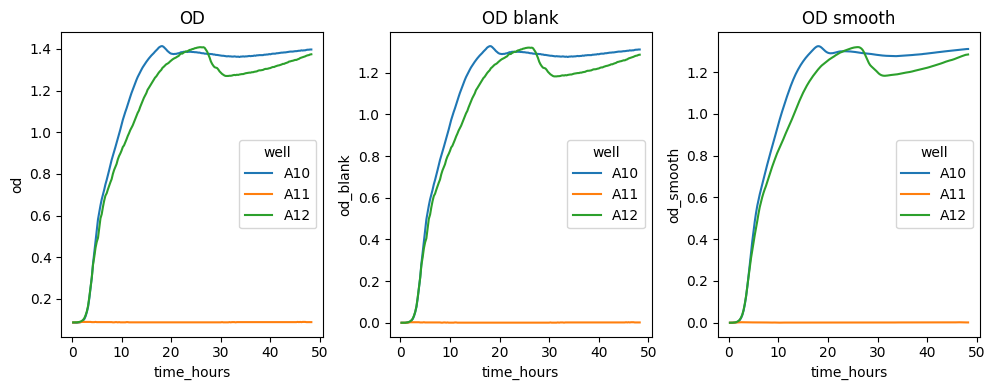

In [73]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True)
axes[0].set_title("OD")
sns.lineplot(data=mask,x="time_hours",y="od",hue="well",ax=axes[0])
axes[1].set_title("OD blank")
sns.lineplot(data=mask,x="time_hours",y="od_blank",hue="well",ax=axes[1])
axes[2].set_title("OD smooth")
sns.lineplot(data=mask,x="time_hours",y="od_smooth",hue="well",ax=axes[2])

# axes[0].set_ylim(-0.3, 0.3)
# axes[1].set_ylim(-0.3, 0.3)
# axes[2].set_ylim(-0.3, 0.3)

plt.tight_layout()


###  Smoothing With Different Windows

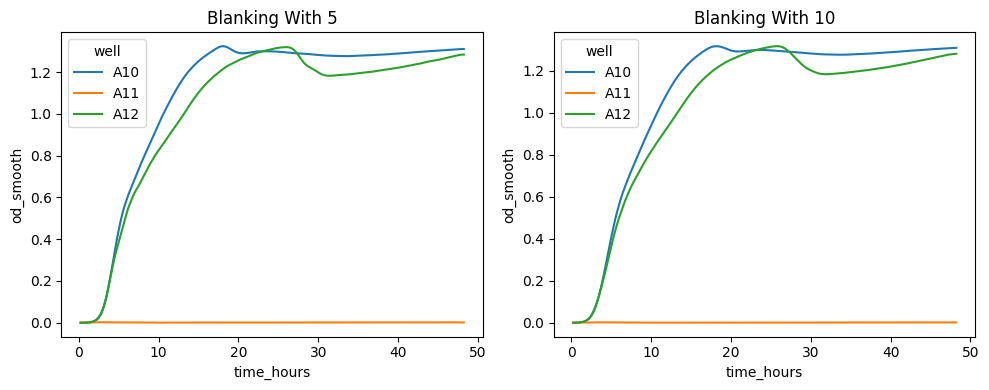

In [74]:
# Compare smoothing with different window sizes
blank5 = with_smoothed_od(blanked, window=5)
blank10 = with_smoothed_od(blanked, window=10)
mask5 = blank5[(blank5["well"] == "A10") | (blank5["well"] == "A11") | (blank5["well"] == "A12")]
mask10 = blank10[(blank10["well"] == "A10") | (blank10["well"] == "A11") | (blank10["well"] == "A12")]
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
axes[0].set_title("Blanking With 5")
sns.lineplot(data=mask5, x="time_hours", y="od_smooth", hue="well", ax=axes[0])
axes[1].set_title("Blanking With 10")
sns.lineplot(data=mask10, x="time_hours", y="od_smooth", hue="well", ax=axes[1])

plt.tight_layout()

### Growth Rate With Different Windows

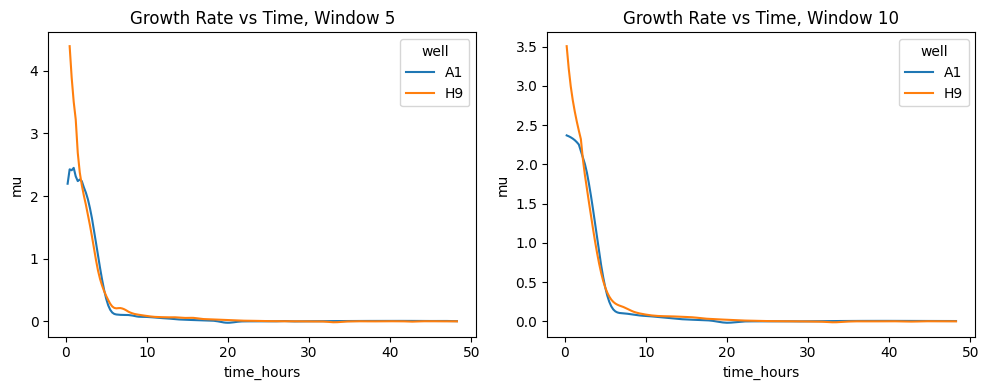

In [75]:
# Compare growth-rate estimates with different window durations
mu5 = add_growth_rate(with_mu, 5)
mu10 = add_growth_rate(smoothed, window=10)
mask5 = mu5[(mu5["well"] == "A1") | (mu5["well"] == "H9")]
mask10 = mu10[(mu10["well"] == "A1") | (mu10["well"] == "H9")]
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
axes[0].set_title("Growth Rate vs Time, Window 5")
sns.lineplot(data=mask5, x="time_hours", y="mu", hue="well", ax=axes[0])
axes[1].set_title("Growth Rate vs Time, Window 10")
sns.lineplot(data=mask10, x="time_hours", y="mu", hue="well", ax=axes[1])
plt.tight_layout()

### Growth Rate With and Without Threshold

### Why threshold from blanked OD and mu from smoothed OD?

Early-OD thresholding should reflect the baseline after removing media/background, not be influenced by smoothing.
Smoothing can slightly raise low values or dampen noise, which is great for regression stability but can inflate the baseline.
Therefore:

- Compute the threshold from `od_blank` (blank-corrected) to capture the true baseline.
- Compute growth rates and mu-max from `od_smooth` (smoothed) to reduce noise and avoid spurious spikes. 
- Pass the blank-based threshold into `summarize_mu_max(...)` so window scans use a consistent, conservative cutoff.

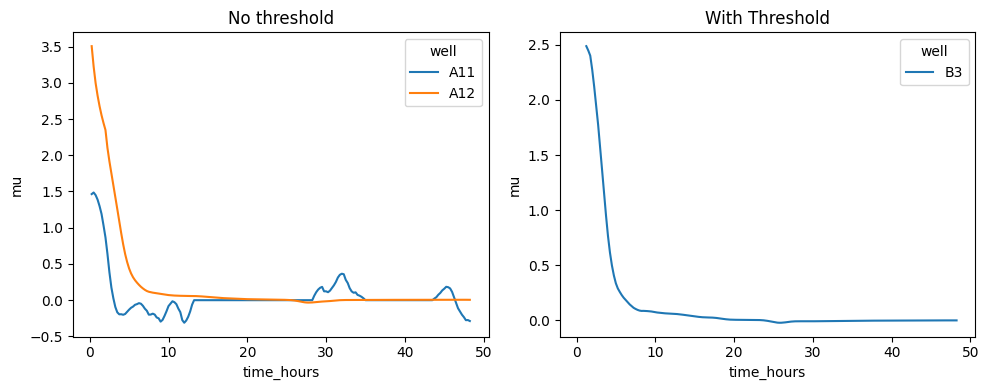

In [80]:
# Growth rate (mu) with and without an early-OD threshold
fig, axes = plt.subplots(1,2, figsize=(10, 4), sharex=True)
with_mu_10 = add_growth_rate(smoothed, window=10)

axes[0].set_title("No threshold")
mask1 = (with_mu_10["well"] == "A11") | (with_mu_10["well"] == "A12")
sns.lineplot(data=with_mu_10[mask1], x="time_hours", y="mu", hue="well", ax=axes[0])

axes[1].set_title("With Threshold")
# Estimate threshold from BLANKED OD to avoid smoothing-inflated baselines
threshold = estimate_early_od_threshold(blanked, od_col="od_blank", n_points=5, q=0.95)
mask2 = ((with_mu_10["well"] == "B11") | (with_mu_10["well"] == "B3")) & (with_mu_10["od_smooth"] >= threshold)
sns.lineplot(data=with_mu_10[mask2], x="time_hours", y="mu", hue="well", ax=axes[1])
plt.tight_layout()

## Grouping by Conditions

In [77]:
# Grouping by condition and summarizing mu-max per condition
by_cond = (full.groupby(["strain", "time_hours"], as_index=False)
    .agg(
        od_mean=("od_blank", "mean"),
        od_std=("od_blank", "std"),
        n=("od_blank", "size")
    )
)
unique_conditions = "strain"
# smooth and compute mu grouped by condition
by_cond = with_smoothed_od(by_cond, group_by=unique_conditions, od="od_mean", window=5)
by_cond = add_growth_rate(by_cond, window=10, group_by=unique_conditions, od="od_mean")
# Estimate a global threshold from BLANKED OD (per-well)
threshold = estimate_early_od_threshold(blanked, od_col="od_blank")
by_cond_max_mu = summarize_mu_max(by_cond, threshold=threshold, od="od_smooth", group_by=unique_conditions)
by_cond_max_mu

,well,mu_max,mu_low,mu_high,tau,tau_low,tau_high
0,WT,2.482962,2.303199,2.662726,0.279161,0.260315,0.300950
1,ΔCA,1.119937,0.837238,1.402636,0.618916,0.494175,0.827897
2,ΔCA+CA,2.462490,2.213682,2.711298,0.281482,0.255651,0.313120


Now lets plot by condition

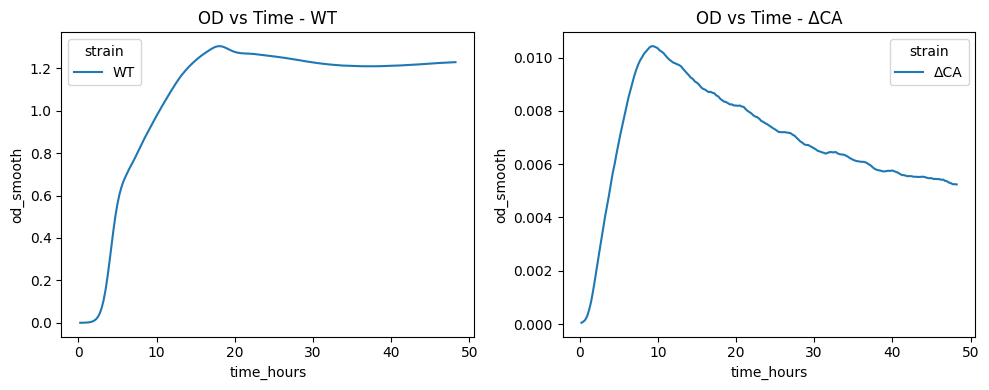

In [78]:
mask = (by_cond["strain"] == "WT")
mask2 = (by_cond["strain"] == "ΔCA")
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
axes[0].set_title("OD vs Time - WT")
sns.lineplot(data=by_cond[mask],x="time_hours",y="od_smooth",hue="strain",ax=axes[0])
axes[1].set_title("OD vs Time - ΔCA")
sns.lineplot(data=by_cond[mask2],x="time_hours",y="od_smooth",hue="strain",ax=axes[1])
plt.tight_layout()

